In [ ]:
!unzip hw5_code.zip

In [ ]:
import random
import pandas as pd

In [ ]:
# You may want to install "gprof2dot"
import io
from collections import Counter

import numpy as np
import scipy.io
import sklearn.model_selection
import sklearn.tree
from numpy import genfromtxt
from scipy import stats
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy import stats

import pydot

eps = 1e-5  # a small number


class DecisionTree:
    def __init__(self, max_depth=3, feature_labels=None, m=None):
        self.max_depth = max_depth
        self.features = feature_labels
        self.left, self.right = None, None  # for non-leaf nodes
        self.split_idx, self.thresh = None, None  # for non-leaf nodes
        self.data, self.pred = None, None  # for leaf nodes
        self.m = m
    
    @staticmethod
    def information_gain(X, y, thresh):
        # EQUIVALENT TO H(S) - H(AFTER)
        # TODO: implement information gain 
        ### CHANGE H_AFTER ### 
        left_labels = y[np.where(X >= thresh)]
        right_labels = y[np.where(X < thresh)]
        before = DecisionTree.gini_impurity(X, y, thresh)

        left = DecisionTree.gini_impurity(X, left_labels, thresh)
        right = DecisionTree.gini_impurity(X, right_labels, thresh)

        after = (len(left_labels)*left + len(right_labels)*right)/len(y)
        return before - after
        #return np.random.rand()

    @staticmethod
    def gini_impurity(X, y, thresh):
        total = len(y)
        count = 0
        entropy = 0
        for surv in np.unique(y):
          for val in y:
            if surv == val:
              count += 1
          p = count/total
          entropy += (-1 * p * np.log2(p))
          count = 0
        #print(entropy)  
        return entropy
        # TODO: implement gini impurity function
        # pass

    def split(self, X, y, idx, thresh):
        X0, idx0, X1, idx1 = self.split_test(X, idx=idx, thresh=thresh)
        y0, y1 = y[idx0], y[idx1]
        return X0, y0, X1, y1

    def split_test(self, X, idx, thresh):
        idx0 = np.where(X[:, idx] < thresh)[0]
        idx1 = np.where(X[:, idx] >= thresh)[0]
        X0, X1 = X[idx0, :], X[idx1, :]
        return X0, idx0, X1, idx1

    def fit(self, X, y):
        if self.max_depth > 0:
            # compute entropy gain for all single-dimension splits,
            # thresholding with a linear interpolation of 10 values
            gains = []
            # The following logic prevents thresholding on exactly the minimum
            # or maximum values, which may not lead to any meaningful node
            # splits.
            # X = pd.DataFrame(X)
            old_X = X
            if self.m:
              # arr = [random.choice(range(len(x_df))) for i in range(self.n)]
              # new_points = x_df.iloc[arr]

              arr = [random.choice(range(len(self.features))) for i in range(self.m)]
              # m_chosen = self.features[arr] # fix?
              
              for a in arr:
                np.append(X, old_X[a])
              #m_chosen = [self.features[i] for i in arr]
              # m_chosen = [True  if i in arr else False for i in range(len(self.features))]
              #X = old_X[m_chosen]
            thresh = np.array([
                np.linspace(np.min(X[:, i]) + eps, np.max(X[:, i]) - eps, num=10)
                for i in range(X.shape[1])
            ])
            for i in range(X.shape[1]):
                gains.append([self.information_gain(X[:, i], y, t) for t in thresh[i, :]])

            gains = np.nan_to_num(np.array(gains))
            self.split_idx, thresh_idx = np.unravel_index(np.argmax(gains), gains.shape)
            self.thresh = thresh[self.split_idx, thresh_idx]
            X0, y0, X1, y1 = self.split(old_X, y, idx=self.split_idx, thresh=self.thresh)
            if X0.size > 0 and X1.size > 0:
                self.left = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.left.fit(X0, y0)
                self.right = DecisionTree(
                    max_depth=self.max_depth - 1, feature_labels=self.features)
                self.right.fit(X1, y1)
            else:
                self.max_depth = 0
                self.data, self.labels = old_X, y
                self.pred = stats.mode(y).mode[0]
        else:
            self.data, self.labels = X, y
            self.pred = stats.mode(y).mode[0]
        return self

    def predict(self, X):
        if self.max_depth == 0:
            return self.pred * np.ones(X.shape[0])
        else:
            X0, idx0, X1, idx1 = self.split_test(X, idx=self.split_idx, thresh=self.thresh)
            yhat = np.zeros(X.shape[0])
            yhat[idx0] = self.left.predict(X0)
            yhat[idx1] = self.right.predict(X1)
            return yhat

    def __repr__(self):
        if self.max_depth == 0:
            return "%s (%s)" % (self.pred, self.labels.size)
        else:
            return "[%s < %s: %s | %s]" % (self.features[self.split_idx],
                                           self.thresh, self.left.__repr__(),
                                           self.right.__repr__())


class BaggedTrees(BaseEstimator, ClassifierMixin):
    def __init__(self, params=None, n=200):
        if params is None:
            params = {}
        self.params = params
        self.n = n
        self.decision_trees = [DecisionTree(max_depth = self.params["max_depth"], feature_labels = None) for i in range(self.n)]
        #self.decision_trees = [
        #    sklearn.tree.DecisionTreeClassifier(random_state=i, **self.params)
        #    for i in range(self.n)
        #]

    def fit(self, X, y):
        # TODO: implement function
        # get random subsamples of data (in this case features) and predict on those with T trees
        #random.choices

        x_df = pd.DataFrame(X)
        x_df['y'] = y
        for tree in self.decision_trees:
          arr = [random.choice(range(len(x_df))) for i in range(self.n)]
          new_points = x_df.iloc[arr]
          new_X = new_points.drop('y', axis = 1).to_numpy()
          tree.fit(new_X, new_points["y"].to_numpy())


    def predict(self, X):
        # TODO: implement function
        pred = []
        for tree in self.decision_trees:
          pred += [tree.predict(X)]
        return stats.mode(pred).mode[0]


class RandomForest(BaggedTrees):
    def __init__(self, params=None, n=200, m=1, feature_labels=None):
        if params is None:
            params = {}
        self.params = params
        self.n = n
        self.m = m
        self.features = feature_labels
        self.decision_trees = [DecisionTree(feature_labels = self.features, max_depth = self.params["max_depth"], m=self.m) for i in range(self.n)]


class BoostedRandomForest(RandomForest):
    def fit(self, X, y):
        self.w = np.ones(X.shape[0]) / X.shape[0]  # Weights on data
        self.a = np.zeros(self.n)  # Weights on decision trees
        # TODO: implement function
        return self

    def predict(self, X):
        # TODO: implement function
        pass


def preprocess(data, fill_mode=True, min_freq=10, onehot_cols=[]):
    # fill_mode = False

    # Temporarily assign -1 to missing data
    data[data == ''] = '-1'

    # Hash the columns (used for handling strings)
    onehot_encoding = []
    onehot_features = []
    for col in onehot_cols:
        counter = Counter(data[:, col])
        for term in counter.most_common():
            if term[0] == '-1':
                continue
            if term[-1] <= min_freq:
                break
            onehot_features.append(term[0])
            onehot_encoding.append((data[:, col] == term[0]).astype(float))
        data[:, col] = '0'
    onehot_encoding = np.array(onehot_encoding).T
    data = np.hstack([np.array(data, dtype=float), np.array(onehot_encoding)])

    # Replace missing data with the mode value. We use the mode instead of
    # the mean or median because this makes more sense for categorical
    # features such as gender or cabin type, which are not ordered.
    if fill_mode:
        for i in range(data.shape[-1]):
            mode = stats.mode(data[((data[:, i] < -1 - eps) +
                                    (data[:, i] > -1 + eps))][:, i]).mode[0]
            data[(data[:, i] > -1 - eps) * (data[:, i] < -1 + eps)][:, i] = mode

    return data, onehot_features


def evaluate(clf):
    print("Cross validation", sklearn.model_selection.cross_val_score(clf, X, y))
    if hasattr(clf, "decision_trees"):
        counter = Counter([t.tree_.feature[0] for t in clf.decision_trees])
        first_splits = [(features[term[0]], term[1]) for term in counter.most_common()]
        print("First splits", first_splits)


if __name__ == "__main__":
    dataset = "titanic"
    #dataset = "spam"
    params = {
        "max_depth": 3,
        # "random_state": 6,
        "min_samples_leaf": 10,
    }
    N = 100

    if dataset == "titanic":
        # Load titanic data
        path_train = 'hw5_code/dataset/titanic/titanic_training.csv'
        data = genfromtxt(path_train, delimiter=',', dtype=None, encoding=None)
        path_test = 'hw5_code/dataset/titanic/titanic_test_data.csv'
        test_data = genfromtxt(path_test, delimiter=',', dtype=None, encoding=None)
        y = data[1:, -1]  # label = survived
        class_names = ["Died", "Survived"]
        labeled_idx = np.where(y != '')[0]

        y = np.array(y[labeled_idx])
        y = y.astype(float).astype(int)


        print("\n\nPart (b): preprocessing the titanic dataset")
        X, onehot_features = preprocess(data[1:, :-1], onehot_cols=[1, 5, 7, 8])
        X = X[labeled_idx, :]
        Z, _ = preprocess(test_data[1:, :], onehot_cols=[1, 5, 7, 8])
        assert X.shape[1] == Z.shape[1]
        features = list(data[0, :-1]) + onehot_features

    elif dataset == "spam":
        features = [
            "pain", "private", "bank", "money", "drug", "spam", "prescription", "creative",
            "height", "featured", "differ", "width", "other", "energy", "business", "message",
            "volumes", "revision", "path", "meter", "memo", "planning", "pleased", "record", "out",
            "semicolon", "dollar", "sharp", "exclamation", "parenthesis", "square_bracket",
            "ampersand"
        ]
        assert len(features) == 32

        # Load spam data
        path_train = 'hw5_code/dataset/spam/spam_data.mat'
        data = scipy.io.loadmat(path_train)
        X = data['training_data']
        y = np.squeeze(data['training_labels'])
        Z = data['test_data']
        class_names = ["Ham", "Spam"]

    else:
        raise NotImplementedError("Dataset %s not handled" % dataset)

    print("Features:", features)
    print("Train/test size:", X.shape, Z.shape)

    print("\n\nPart 0: constant classifier")
    print("Accuracy", 1 - np.sum(y) / y.size)

    # Basic decision tree
    print("\n\nPart (a-b): simplified decision tree")
    dt = DecisionTree(max_depth=3, feature_labels=features)
    dt.fit(X, y)
    print("Predictions", dt.predict(Z)[:100])

    print("\n\nPart (c): sklearn's decision tree")
    clf = sklearn.tree.DecisionTreeClassifier(random_state=0, **params)
    clf.fit(X, y)
    evaluate(clf)
    out = io.StringIO()

    # You may want to install "gprof2dot"
    sklearn.tree.export_graphviz(
        clf, out_file=out, feature_names=features, class_names=class_names)
    graph = pydot.graph_from_dot_data(out.getvalue())
    pydot.graph_from_dot_data(out.getvalue())[0].write_pdf("%s-tree.pdf" % dataset)

    # TODO: implement and evaluate!

    dt = DecisionTree(max_depth = 1, feature_labels = features)
    bg = BaggedTrees(params = params, n=20)
    rf = RandomForest(params= params, m=20, n=30, feature_labels=features)



Part (b): preprocessing the titanic dataset
Features: ['pclass', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'embarked', 'male', 'female', 'S', 'C', 'Q']
Train/test size: (999, 14) (310, 14)


Part 0: constant classifier
Accuracy 0.6166166166166166


Part (a-b): simplified decision tree


<ipython-input-181-487e8b9a4eef>:224: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(data[((data[:, i] < -1 - eps) +
<ipython-input-181-487e8b9a4eef>:118: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self.pred = stats.mode(y).mode[0]


Predictions [1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1.
 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0.]


Part (c): sklearn's decision tree
Cross validation [0.82       0.83       0.8        0.75       0.75879397]


In [ ]:
train = pd.DataFrame(X)
train["y"] = y
train = train.sample(frac=1)
val = train[:int(len(train)*0.25)]
train = train[int(len(train)*0.25):]

In [ ]:
bg.fit(train.drop("y", axis = 1), train["y"])

<ipython-input-181-487e8b9a4eef>:118: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self.pred = stats.mode(y).mode[0]


In [ ]:
rf.fit(train.drop("y", axis = 1), train["y"])

In [ ]:
pred_train = bg.predict(train.to_numpy())
pred_val = bg.predict(val.to_numpy())

<ipython-input-149-f5afdb118483>:171: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  return stats.mode(pred).mode[0]


In [ ]:
train_labs = pd.Series.to_numpy(train['y'])
val_labs = pd.Series.to_numpy(val['y'])

In [ ]:
# TITANIC BAGGED TRAINING ACCURACY
counter = 0
for i in range(len(train_labs)):
  if train_labs[i] == pred_train[i]:
    counter += 1
print(counter / len(train_labs))

0.7973333333333333


In [ ]:
# TITANIC BAGGED VALIDATION ACCURACY
counter = 0
for i in range(len(val_labs)):
  if val_labs[i] == pred_val[i]:
    counter += 1
print(counter / len(val_labs))

0.8433734939759037


In [ ]:
pred_train = rf.predict(train.to_numpy())
pred_val = rf.predict(val.to_numpy())

<ipython-input-94-ffa8dd338d7d>:171: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  return stats.mode(pred).mode[0]


In [ ]:
# TITANIC RANDOM FOREST TRAINING ACCURACY
counter = 0
for i in range(len(train_labs)):
  if train_labs[i] == pred_train[i]:
    counter += 1
print(counter / len(train_labs))

0.7866666666666666


In [ ]:
# TITANIC RANDOM FOREST VALIDATION ACCURACY
counter = 0
for i in range(len(val_labs)):
  if val_labs[i] == pred_val[i]:
    counter += 1
print(counter / len(val_labs))

0.7911646586345381


In [ ]:
train = pd.DataFrame(X)
train["y"] = y
train = train.sample(frac=1)
val = train[:int(len(train)*0.25)]
train = train[int(len(train)*0.25):]

In [ ]:
bg.fit(train.drop("y", axis = 1), train["y"])
rf.fit(train.drop("y", axis = 1), train["y"])

In [ ]:
pred_train = bg.predict(train.to_numpy())
pred_val = bg.predict(val.to_numpy())

<ipython-input-32-470662c6d67a>:171: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  return stats.mode(pred).mode[0]


In [ ]:
train_labs = pd.Series.to_numpy(train['y'])
val_labs = pd.Series.to_numpy(val['y'])

In [ ]:
# SPAM BAGGED TRAINING ACCURACY
counter = 0
for i in range(len(train_labs)):
  if train_labs[i] == pred_train[i]:
    counter += 1
print(counter / len(train_labs))

# SPAM BAGGED VALIDATION ACCURACY
counter = 0
for i in range(len(val_labs)):
  if val_labs[i] == pred_val[i]:
    counter += 1
print(counter / len(val_labs))

0.797979797979798
0.7962121212121213


In [ ]:
pred_train = rf.predict(train.to_numpy())
pred_val = rf.predict(val.to_numpy())

<ipython-input-32-470662c6d67a>:171: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  return stats.mode(pred).mode[0]


In [ ]:
# SPAM RANDOM FOREST TRAINING ACCURACY
counter = 0
for i in range(len(train_labs)):
  if train_labs[i] == pred_train[i]:
    counter += 1
print(counter / len(train_labs))

# SPAM RANDOM FOREST VALIDATION ACCURACY
counter = 0
for i in range(len(val_labs)):
  if val_labs[i] == pred_val[i]:
    counter += 1
print(counter / len(val_labs))

0.8002525252525252
0.8053030303030303


In [ ]:
test = data['test_data']

In [ ]:
spam_preds = rf.predict(test)

<ipython-input-32-470662c6d67a>:171: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  return stats.mode(pred).mode[0]


In [ ]:
print(int(spam_preds[4]))

1


In [ ]:
spam_ints = [0] * len(spam_preds)
for i in range(len(spam_preds)):
  spam_ints[i] = int(spam_preds[i])

In [ ]:
spam_ints

In [ ]:
ind_spam = [i + 1 for i in range(len(spam_ints))]
df_spam = pd.DataFrame({"Id": ind_spam, "Category": spam_ints})
df_spam

,Id,Category
0,1,0
1,2,0
2,3,0
3,4,0
4,5,1
...,...,...
5744,5745,0
5745,5746,0
5746,5747,0
5747,5748,0


In [ ]:
compression_opts_spam = dict(method='zip', archive_name='out_spam.csv')  
df_spam.to_csv('out_spam.zip', index=False, compression=compression_opts_spam) 

1.   **SPAM KAGGLE SCORE: .80394**
2.   Username: Rayan Taghizadeh



In [ ]:
titanic_preds = bg.predict(Z)

<ipython-input-94-ffa8dd338d7d>:171: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  return stats.mode(pred).mode[0]


In [ ]:
len(titanic_preds)

310

In [ ]:
titanic_ints = [0] * len(titanic_preds)
for i in range(len(titanic_preds)):
  titanic_ints[i] = int(titanic_preds[i])

In [ ]:
len(titanic_ints)

310

In [ ]:
ind_tit = [i + 1 for i in range(len(titanic_ints))]
df_tit = pd.DataFrame({"Id": ind_tit, "Category": titanic_ints})
df_tit

,Id,Category
0,1,1
1,2,0
2,3,0
3,4,0
4,5,1
...,...,...
305,306,0
306,307,0
307,308,0
308,309,1


In [ ]:
compression_opts_spam = dict(method='zip', archive_name='out_tit5.csv')  
df_tit.to_csv('out_tit5.zip', index=False, compression=compression_opts_spam)

1.   **TITANIC KAGGLE SCORE: .79354**
2.   Username: Rayan Taghizadeh

In [ ]:
train = pd.DataFrame(X)
train["y"] = y
train = train.sample(frac=1)
val = train[:int(len(train)*0.2)]
train = train[int(len(train)*0.2):]

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
train_ls = []
val_ls = []
for i in range(40):
  params["max_depth"] = i
  bg = BaggedTrees(params = params, n=30)
  bg.fit(train.drop("y", axis = 1), train["y"])
#train = bg.predict(train)
#val = bg.predict(val)
  valp = bg.predict(val.to_numpy())
  val_labs = pd.Series.to_numpy(val['y'])
  val_ls += [accuracy_score(val_labs, valp)]

In [ ]:
import matplotlib.pyplot as plt

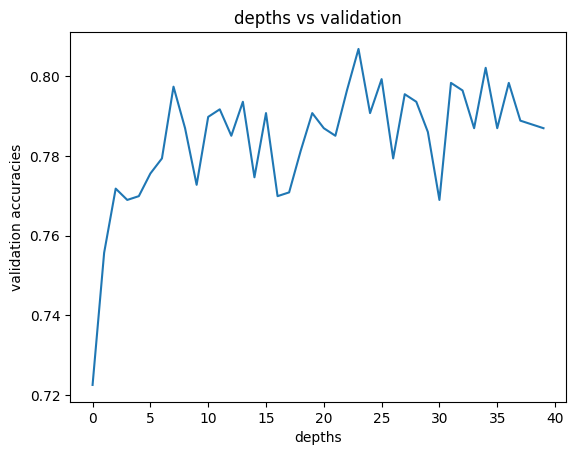

In [ ]:
depths = [i for i in range(40)]
plt.plot(depths, val_ls)
plt.title("depths vs validation")
plt.xlabel("depths")
plt.ylabel("validation accuracies")
plt.show()